1. Добиться хорошего результата от модели, собранной на занятии (5 угаданныx картинок из 8 предложенных). Варианты изменений:<br>
изменение слоёв и их количества;<br>
изменение метода оптимизации;<br>
изменение процесса обучения;<br>
*преобразование данных transform<br>
2.*Переписать данный туториал на PyTorch: https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ru

In [1]:
import numpy as np
import pandas as pd

import torch
from torch import optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn

import matplotlib.pyplot as plt

from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


__Ниже перепишу часть кода с урока и непосредственно саму модель, которую нужно улучшить:__

In [3]:
# ЗАГРУЗКА ТРЕЙНА И ТЕСТА
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,  # можно таким же образом скачать тестовую часть
                                             transform=transforms.ToTensor(), #чтобы сразу преобразовывалось в корректный тип и тут нормировка происходит сразу 
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())


image, label = train_dataset[0]
print(image.size())
print(label)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified
torch.Size([3, 32, 32])
6


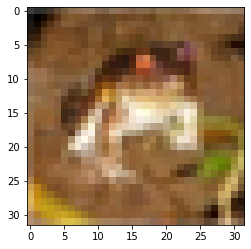

In [4]:
# plt требует классического вида shape, потому преобразовали через пермут

plt.imshow(image.permute(1, 2, 0).numpy()); # 1 2 0 - это индексы изначальноых параметров image

In [5]:
# НАСТРОЙКА ПОДАЧИ КАРТИНОК С ТЕСТА  ТРЕЙНА В DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, # какой кусок объектов выдавать. 64 картинки
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8,
                                          shuffle=False)

In [6]:
# НАЗВАНИЯ КЛАССОВ ДАТАСЕТА - ВСЕГО 10 КЛАССОВ
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
# МОДЕЛЬ С УРОКА
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 4 * hidden_dim)     # инициализиурем 4 слоя
        self.fc2 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1) # вытягиваем в одномерный вектор - аналог flatten
        x = self.fc1(x)      # прононяем по первому слою
        x = F.leaky_relu(x)  # применяем функцию активации лики релу
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)      # на четвертом слое не сделали ф-цию активации, тут многоклассовость и д.б. софт макс, мы ее в предсказании сделаем
        return x             # в прямом проходе всегда следует останавливаться на том, что идет в ф-цию активации в конце и не писать ее,т.к. ф-ции потерь считаются в торче
                             # на логитах, а логиты это то что идет в ф-цию активации
    
    def predict(self, x):            # тот же форвард, но с софтмаксов на конце (выделяет 1 класс из логитов)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x) 
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        x = F.softmax(x)
        return x


net = Net(3072, 100, 10)  # 3072 это кол-во каналов при входе усноженное на размерность картинки: 3 * 32 * 32
net.train()

criterion = nn.CrossEntropyLoss()  # ф-ция потерь в торче использует именно логиты. получается что с forward поступают логиты и она их считывает, поэтому нет в конце активации выше
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0) # net.parameters() это мы так указываем подгружая параметры модели

num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    running_items = 0.0


    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

         # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}')
            running_loss, running_items = 0.0, 0.0

print('Training is finished!')

Epoch [1/5]. Step [1/782]. Loss: 0.036
Epoch [1/5]. Step [301/782]. Loss: 0.036
Epoch [1/5]. Step [601/782]. Loss: 0.035
Epoch [2/5]. Step [1/782]. Loss: 0.034
Epoch [2/5]. Step [301/782]. Loss: 0.032
Epoch [2/5]. Step [601/782]. Loss: 0.031
Epoch [3/5]. Step [1/782]. Loss: 0.029
Epoch [3/5]. Step [301/782]. Loss: 0.030
Epoch [3/5]. Step [601/782]. Loss: 0.030
Epoch [4/5]. Step [1/782]. Loss: 0.027
Epoch [4/5]. Step [301/782]. Loss: 0.029
Epoch [4/5]. Step [601/782]. Loss: 0.029
Epoch [5/5]. Step [1/782]. Loss: 0.028
Epoch [5/5]. Step [301/782]. Loss: 0.028
Epoch [5/5]. Step [601/782]. Loss: 0.028
Training is finished!


In [8]:
# ДАЛЕЕ КАЧЕСТВО РАБОТЫ МОДЕЛИ -СМОТРИМ МЕТРИКУ И ПРЕДМЕСТНО КАК УГАДЫВАЕТ КАРТИНКИ
data_iter = iter(test_loader)
images, labels = next(data_iter)

GroundTruth:  cat ship ship plane frog frog car frog


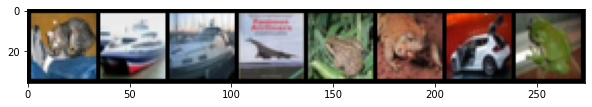

In [9]:
net.eval()
outputs = net(images)  # говорит что net(images) это равнозначно net.forward(images) типа можно упрощать 
imgs = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

In [10]:
_, predicted = torch.max(outputs, 1)

predicted

tensor([5, 9, 8, 8, 4, 6, 5, 4])

In [11]:
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['dog' 'truck' 'ship' 'ship' 'deer' 'frog' 'dog' 'deer']
Accuracy is 0.25


__РЕШЕНИЕ:__<br>
Cначала проверяем предоставляет ли в данный момент колаб возможность использования GPU.
<br>

если да, то в цикле ниже и модель и все inputs, labels (трейн и предсказание)нужно положить на GPU через метод .to_device(device)

На этапе выполнения 72 итераций ниже я подключил себе версию про на колабе и имел доступ к видеокарте НВИДИА с 40гб. памяти, в гугл колабе на странице данной работы в рантайме включил GPU и потом на gpu клал саму тестируемую модель нейросети и inputs & labels (все входы в нее), однако на скорость обучения это не повлияло - увидим ниже.

In [12]:
print(f"Поддерживается ли CUDA : {torch.cuda.is_available()}")
print(f'Количество гпу девайсов: {torch.cuda.device_count()}')
print(f"Характеристики видеокарты : {torch.cuda.get_device_properties(0)}")
print(f"Удаляем всю незанятую память через torch.cuda.empty_cache()")

Поддерживается ли CUDA : True
Количество гпу девайсов: 1
Характеристики видеокарты : _CudaDeviceProperties(name='NVIDIA A100-SXM4-40GB', major=8, minor=0, total_memory=40513MB, multi_processor_count=108)
Удаляем всю незанятую память через torch.cuda.empty_cache()


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
device

device(type='cuda', index=0)

__Я решил одновременно прогонять по циклу и смотреть качество работы моделей по следующим параметрам:__
* кол-во скрытых слоев нейросети (для этого ниже настроил универсальный способ создания сети),
* кол-во нейронов,
* кол-во эпох обучения каждой сети,
* скорость обучения оптимизатора.

In [14]:
# МОЯ ХИТРО НАПИСАННАЯ МОДЕЛЬ С ВОЗМОЖНОСТЬЮ АВТОМАТИЧЕСКОГО СОЗДАНИЯ СКРЫТЫХ СЛОЕВ СКОЛЬКО ХОЧЕШЬ 
class My_Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=3):
        super().__init__()
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        
        # ниже примерная логика как можно изменять кол-во нейронов от слоя к слою, чтобы выходные из предыдущего равнялись кол-ву входных следующего слоя
        self.layers.append(nn.Linear(input_dim, (2 ** (n_layers - 2)) * hidden_dim)) # первый слой вне цикла, т.к. инпуты тут фиксированные, а в цикле будем подбирать
        for i in range(1, n_layers - 1): #  ВООБЩЕ ХОТЕЛОСЬ БЫ чтобы  n_layers отображал именно кол-во скрытых слоев, а не всего слоев
          self.layers.append(nn.Linear((2 ** (n_layers - i - 1)) * hidden_dim, (2 ** (n_layers - i - 2)) * hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        x = x.view(x.shape[0], -1)         # вытягиваем в одномерный вектор - аналог flatten
        for layer in self.layers[:-1]: # последний не берем, т.к. для него не нужна активация
          x = layer(x)             # прононяем по слою
          x = F.leaky_relu(x)      # применяем функцию активации лики релу
        x = self.layers[-1](x)
        return x
  


__Далее будет долгий цикл и чтобы колаб не спрашивал подверждения что я работ при ожидании обучения нейросети в не активном режиме (я ушел от компа), настроил кликер в javascript браузера (в консоли инспектора)__

<br>
Steps <br>
    Сначала создать пустую строку ввода кода - туда нажать курсор и далее по схеме:<br>
    Open the inspector view by typing Ctrl+ Shift + i and then clicking on console tab at top.
    Paste the below code snippet at bottom of console and hit enter


```
function ClickConnect(){
console.log("Working"); 
document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
}
setInterval(ClickConnect,60000)
```



__Ниже идет тот самый долгий цикл, где я перебираю каждую модель и после последней эпохи записываю параметры, в т.ч. время обучения в секундах. Решил проблему обнуления весов у одной и той же модели, но где перебирается разное кол-во эпох. Все вроде бы корректно.__

<br>

__Примечание по рассчету кросс-энтропии:__ Похоже что, встроенная функция расчитыват усредненный лосс на батче. Поэтому надо в конце эпохи делить аккумулятивный лосс на количество батчей, а не на количество картинок. Именно поэтому лоссы на тесте и на трейне на порядок не сходились в методичке

In [ ]:
import time 

criterion = nn.CrossEntropyLoss()  

num_layers = range(3, 7) # мой класс нейросети Net написан так, что число отсюда это кол-во всего слоев, чтобы увидеть именно число скрытых слоев, нужно отнять 2 (входной, выходной)
n_dims = [10, 30, 50] # в модели нейросети на разных слоях кол-во нейронов будет исчисляться путем умножения взятого числа из n_dims на число от 2 до 8
num_epochs = [5,10,20]
lr_rate = [0.0001, 0.001]

# сюда буду записывать параметры каждой модели
results = pd.DataFrame(columns=['hidden dim', 'learning rate','epochs', 'time (sec)','train loss','test loss', 'train acc', 'test acc'])

count = 1
for l in num_layers:
  for dim in n_dims:
    torch.cuda.empty_cache()
    net_to_examine = Net(input_dim=3072, hidden_dim=dim, output_dim=10, n_layers=l).to(device)  # 3072 размерность картинки * входы: 32*32*3, а 10 - кол-во классов

    for rate in lr_rate:
      optimizer = optim.Adam(net_to_examine.parameters(), lr=rate)

      for n in num_epochs:
        start = time.time() # буду сравнивать время обучения каждой модели

        # включаем обучение
        net_to_examine.train()

        for epoch in range(n):
            running_loss = 0.0
            running_items = 0.0
            running_loss_test = 0.0
            running_items_test = 0.0
            running_right = 0.0
            running_right_test = 0.0

            #net_to_examine.train() сли тут, то последние веса прошлой модели идут в первую эпоху следующей модели
            for i, data in enumerate(train_loader):
                
                inputs, labels = data[0].to(device), data[1].to(device)

                # Обнуляем градиент внутри каждой эпохи итерируемых эпох 1 модели
                optimizer.zero_grad()
                # Делаем предсказание
                outputs = net_to_examine(inputs)
                # Рассчитываем лосс-функцию
                loss = criterion(outputs, labels)
                # Делаем шаг назад по лоссу
                loss.backward()
                # Делаем шаг нашего оптимайзера
                optimizer.step()

                # выводим статистику о процессе обучения
                running_loss += loss.item()
                running_items += len(labels)
                running_right += (labels == torch.max(outputs, 1)[1]).sum()

            running_right = running_right.item()
            train_loss = running_loss / i
            train_acc = running_right / running_items
            print(f'Epoch [{epoch + 1}/{n}]. ' \
                  f'Loss_train: {train_loss:.4f}. ' \
                  f'Acc: {train_acc:.4f}.', end=' ')
            

            net_to_examine.eval()
            for i, data in enumerate(test_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                # Делаем предсказание
                outputs = net_to_examine(inputs)
                # Рассчитываем лосс-функцию
                loss = criterion(outputs, labels)

                running_loss_test += loss.item()
                running_items_test += len(labels)
                running_right_test += (labels == torch.max(outputs, 1)[1]).sum()

            running_right_test = running_right_test.item()
            test_loss = running_loss_test / i
            test_acc = running_right_test / running_items_test
            print(f'Loss_test: {test_loss:.4f}. ' \
                  f'Acc_test: {test_acc:.4f}')


            # итерация одной модели со всеми проверяемыми параметрами заканчивается после отработки последней эпохи и именно тут записыываем скор и считаем время
            if (epoch +1) == n:
              end = time.time() - start
              results = results.append({'hidden layers': l-2,  # считать буду только скрытые слои, т.к. именно эта инф. полезна - зачем учитывать входной и выходной слой
                              'hidden dim': dim,
                              'learning rate': rate,
                              'epochs': n,
                              'time (sec)': int(end),
                              'train loss': train_loss,
                              'test loss': test_loss,
                              'train acc': train_acc, 
                              'test acc': test_acc}, ignore_index=True)
              
              # чтобы понимать сколько еще осталось ждать до окончания цикла
              print(f'Завершилось обучение модели № {count} из {len(n_dims)*len(num_epochs)*len(lr_rate)*len(num_layers)}\n')
              count += 1

              if count % 24 == 0:
                results.to_csv(f'Grid_Search_result 1 - {count}.csv', index = False)
                files.download('Grid_Search_result 1 - {count}.csv')

              #перезаписывая модель заново таким образом обнуляю веса с последней эпохи  перед включением трейна обратно
              net_to_examine = Net(input_dim=3072, hidden_dim=dim, output_dim=10, n_layers=l).to(device)
              optimizer = optim.Adam(net_to_examine.parameters(), lr=rate)

            # независимо последняя эпоха или нет, после каждой эпохи обнуляем значения для подсчета метрик
            running_loss_test, running_items_test, running_right_test = 0.0, 0.0, 0.0
            running_loss, running_items, running_right = 0.0, 0.0, 0.0


print('Training is finished!')

results.to_csv('Grid_Search_result FINAL.csv', index = False)
files.download('Grid_Search_result FINAL.csv')

__Я скачивал в цикле данные и по итогам цикла и далее я сейчас погружу весь результат работы цикла (чтобы заново не запускать цикл):__

In [17]:
with open('/content/drive/MyDrive/PROJECTS/Grid_Search_result FINAL.csv', "rb") as f:
    results = pd.read_csv(f)
    
results

,hidden dim,learning rate,epochs,time (sec),train loss,test loss,train acc,test acc,hidden layers
0,10.0,0.0001,5.0,66.0,1.839054,1.825286,0.34396,0.3504,1.0
1,10.0,0.0001,10.0,133.0,1.782870,1.772126,0.36406,0.3561,1.0
2,10.0,0.0001,20.0,269.0,1.686404,1.685954,0.40296,0.3991,1.0
3,10.0,0.0010,5.0,68.0,1.734362,1.753873,0.37722,0.3667,1.0
4,10.0,0.0010,10.0,137.0,1.610634,1.613919,0.42088,0.4208,1.0
...,...,...,...,...,...,...,...,...,...
67,50.0,0.0001,10.0,153.0,1.369244,1.449576,0.51078,0.4796,4.0
68,50.0,0.0001,20.0,301.0,1.125941,1.344195,0.60004,0.5270,4.0
69,50.0,0.0010,5.0,75.0,1.532476,1.508459,0.44944,0.4611,4.0
70,50.0,0.0010,10.0,150.0,1.368618,1.451677,0.50964,0.4890,4.0


In [18]:
# т.к. время в секундах, то хочу веревести в минуты
results['time (sec)'] = results['time (sec)'].apply(lambda x: float(str(f'{x / 60: .2f}')))

In [19]:
results

,hidden dim,learning rate,epochs,time (sec),train loss,test loss,train acc,test acc,hidden layers
0,10.0,0.0001,5.0,1.10,1.839054,1.825286,0.34396,0.3504,1.0
1,10.0,0.0001,10.0,2.22,1.782870,1.772126,0.36406,0.3561,1.0
2,10.0,0.0001,20.0,4.48,1.686404,1.685954,0.40296,0.3991,1.0
3,10.0,0.0010,5.0,1.13,1.734362,1.753873,0.37722,0.3667,1.0
4,10.0,0.0010,10.0,2.28,1.610634,1.613919,0.42088,0.4208,1.0
...,...,...,...,...,...,...,...,...,...
67,50.0,0.0001,10.0,2.55,1.369244,1.449576,0.51078,0.4796,4.0
68,50.0,0.0001,20.0,5.02,1.125941,1.344195,0.60004,0.5270,4.0
69,50.0,0.0010,5.0,1.25,1.532476,1.508459,0.44944,0.4611,4.0
70,50.0,0.0010,10.0,2.50,1.368618,1.451677,0.50964,0.4890,4.0


In [20]:
# чтобы название теперь соответствовало цифрам перепишу его - можно было сразу сделать в цикле кстати
results.rename(columns={'time (sec)': 'time (min)'}, inplace=True)
results.head(3)

,hidden dim,learning rate,epochs,time (min),train loss,test loss,train acc,test acc,hidden layers
0,10.0,0.0001,5.0,1.10,1.839054,1.825286,0.34396,0.3504,1.0
1,10.0,0.0001,10.0,2.22,1.782870,1.772126,0.36406,0.3561,1.0
2,10.0,0.0001,20.0,4.48,1.686404,1.685954,0.40296,0.3991,1.0


In [21]:
results['time (min)'].sum() / 60

3.2774999999999994

### Цикл работал 3.5 часа!

In [22]:
# сортирую датафрейм так чтобы сверху был лучший скор и одновременно меньшее время обучения
results.sort_values(['test acc','time (min)'], ascending=[False, True]).head(9)

,hidden dim,learning rate,epochs,time (min),train loss,test loss,train acc,test acc,hidden layers
68,50.0,0.0001,20.0,5.02,1.125941,1.344195,0.60004,0.5270,4.0
62,30.0,0.0001,20.0,4.98,1.246356,1.347606,0.55464,0.5218,4.0
71,50.0,0.0010,20.0,5.05,1.080132,1.422769,0.61016,0.5187,4.0
50,50.0,0.0001,20.0,4.72,1.242474,1.356052,0.55844,0.5186,3.0
65,30.0,0.0010,20.0,4.97,1.130779,1.436516,0.59194,0.5119,4.0
29,30.0,0.0010,20.0,4.65,1.267069,1.388393,0.54678,0.5106,2.0
32,50.0,0.0001,20.0,4.60,1.319564,1.390959,0.53246,0.5083,2.0
35,50.0,0.0010,20.0,4.58,1.194835,1.412914,0.57000,0.5080,2.0
59,10.0,0.0010,20.0,4.83,1.258638,1.407684,0.55236,0.5073,4.0


Видим что победила 68 модель (индекс здесь соответствует номеру итерации в цикле и сотв-но номеру модели).

<br> 

Создам теперь модель именно с этими параметрами и буду ожидать от нее 52% точности на тесте:

In [23]:
final_net = My_Net(input_dim=3072, hidden_dim=50, output_dim=10, n_layers=6) # n_layers указываю на 2 больше, т.к. 4 в таблице это именно
                                                                                       # скрытые слои, т.е. без учета входного и выходного слоя
criterion = nn.CrossEntropyLoss()
final_optimizer = optim.Adam(final_net.parameters(), lr=0.0001)    
epochs = 20

# обучения
for epoch in range(epochs):
    final_net.train() # поскольку у меня в цикле обучения внедрена часть кода проверки предсказания на тесте, то в предсказнии обучени отключаю, а перед обучением надо включать

    running_loss = 0.0
    running_items = 0.0
    running_loss_test = 0.0
    running_items_test = 0.0
    running_right = 0.0
    running_right_test = 0.0

    #net_to_examine.train() сли тут, то последние веса прошлой модели идут в первую эпоху следующей модели
    for i, data in enumerate(train_loader):
        
        inputs, labels = data[0], data[1]

        # Обнуляем градиент внутри каждой эпохи итерируемых эпох 
        final_optimizer.zero_grad()
        # Делаем предсказание
        outputs = final_net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        final_optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()

    running_right = running_right.item()
    train_loss = running_loss / i
    train_acc = running_right / running_items
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Loss_train: {train_loss:.4f}. ' \
          f'Acc: {train_acc:.4f}.', end=' ')
    

    final_net.eval()
    for i, data in enumerate(test_loader):
        inputs, labels = data[0], data[1]
        # Делаем предсказание
        outputs = final_net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)

        running_loss_test += loss.item()
        running_items_test += len(labels)
        running_right_test += (labels == torch.max(outputs, 1)[1]).sum()

    running_right_test = running_right_test.item()
    test_loss = running_loss_test / i
    test_acc = running_right_test / running_items_test
    print(f'Loss_test: {test_loss:.4f}. ' \
          f'Acc_test: {test_acc:.4f}')


    # независимо последняя эпоха или нет, после каждой эпохи обнуляем значения для подсчета метрик
    running_loss_test, running_items_test, running_right_test = 0.0, 0.0, 0.0
    running_loss, running_items, running_right = 0.0, 0.0, 0.0

Epoch [1/20]. Loss_train: 2.0119. Acc: 0.2483. Loss_test: 1.8465. Acc_test: 0.3241
Epoch [2/20]. Loss_train: 1.7864. Acc: 0.3530. Loss_test: 1.7220. Acc_test: 0.3808
Epoch [3/20]. Loss_train: 1.6903. Acc: 0.3883. Loss_test: 1.6785. Acc_test: 0.3928
Epoch [4/20]. Loss_train: 1.6282. Acc: 0.4138. Loss_test: 1.6054. Acc_test: 0.4207
Epoch [5/20]. Loss_train: 1.5719. Acc: 0.4347. Loss_test: 1.5597. Acc_test: 0.4387
Epoch [6/20]. Loss_train: 1.5264. Acc: 0.4522. Loss_test: 1.5000. Acc_test: 0.4636
Epoch [7/20]. Loss_train: 1.4848. Acc: 0.4669. Loss_test: 1.4822. Acc_test: 0.4776
Epoch [8/20]. Loss_train: 1.4499. Acc: 0.4803. Loss_test: 1.5171. Acc_test: 0.4683
Epoch [9/20]. Loss_train: 1.4133. Acc: 0.4943. Loss_test: 1.4554. Acc_test: 0.4820
Epoch [10/20]. Loss_train: 1.3804. Acc: 0.5076. Loss_test: 1.4085. Acc_test: 0.4972
Epoch [11/20]. Loss_train: 1.3522. Acc: 0.5129. Loss_test: 1.4000. Acc_test: 0.4984
Epoch [12/20]. Loss_train: 1.3232. Acc: 0.5266. Loss_test: 1.3792. Acc_test: 0.5102
E

__Финальная часть - смотрим как распознает картинки на примере:__

GroundTruth:  cat ship ship plane frog frog car frog


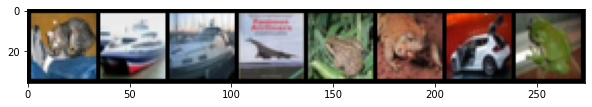

In [24]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

final_net.eval()
outputs = final_net(images)  # final_net(images) это равнозначно final_net.forward(images) - можно упрощать 
imgs = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

In [25]:
_, predicted = torch.max(outputs, 1)

predicted

tensor([1, 8, 0, 0, 4, 6, 1, 6])

In [26]:
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['car' 'ship' 'plane' 'plane' 'deer' 'frog' 'car' 'frog']
Accuracy is 0.625


Итак, модель распознала 6 из 8, в то время как модель с урока распознала только 2

Попробуем сделать то же самое, но без деления на батчи в критерии (делаем как на уроке было):

In [27]:
final_net2 = My_Net(input_dim=3072, hidden_dim=50, output_dim=10, n_layers=6) # n_layers указываю на 2 больше, т.к. 4 в таблице это именно
                                                                                       # скрытые слои, т.е. без учета входного и выходного слоя
criterion = nn.CrossEntropyLoss()
final_optimizer = optim.Adam(final_net2.parameters(), lr=0.0001)    

num_epochs = 20  

for epoch in range(num_epochs):
    running_loss = 0.0
    running_items = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]
        
        # Обнуляем градиент
        final_optimizer.zero_grad()
        # Делаем предсказание
        outputs = final_net2(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        final_optimizer.step()
        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if i % 300 ==0:  # печатаем каждые 300 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}')
            running_loss, running_items = 0.0, 0.0
            
print('Training is finished!')



Epoch [1/20]. Step [1/782]. Loss: 0.036
Epoch [1/20]. Step [301/782]. Loss: 0.033
Epoch [1/20]. Step [601/782]. Loss: 0.031
Epoch [2/20]. Step [1/782]. Loss: 0.030
Epoch [2/20]. Step [301/782]. Loss: 0.029
Epoch [2/20]. Step [601/782]. Loss: 0.028
Epoch [3/20]. Step [1/782]. Loss: 0.026
Epoch [3/20]. Step [301/782]. Loss: 0.027
Epoch [3/20]. Step [601/782]. Loss: 0.027
Epoch [4/20]. Step [1/782]. Loss: 0.023
Epoch [4/20]. Step [301/782]. Loss: 0.026
Epoch [4/20]. Step [601/782]. Loss: 0.025
Epoch [5/20]. Step [1/782]. Loss: 0.027
Epoch [5/20]. Step [301/782]. Loss: 0.025
Epoch [5/20]. Step [601/782]. Loss: 0.025
Epoch [6/20]. Step [1/782]. Loss: 0.021
Epoch [6/20]. Step [301/782]. Loss: 0.024
Epoch [6/20]. Step [601/782]. Loss: 0.024
Epoch [7/20]. Step [1/782]. Loss: 0.020
Epoch [7/20]. Step [301/782]. Loss: 0.023
Epoch [7/20]. Step [601/782]. Loss: 0.023
Epoch [8/20]. Step [1/782]. Loss: 0.021
Epoch [8/20]. Step [301/782]. Loss: 0.023
Epoch [8/20]. Step [601/782]. Loss: 0.023
Epoch [9

GroundTruth:  cat ship ship plane frog frog car frog


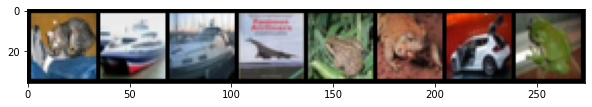

In [28]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

final_net2.eval()
outputs = final_net2(images)  # final_net(images) это равнозначно final_net.forward(images) - можно упрощать 
imgs = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

In [29]:
_, predicted = torch.max(outputs, 1)

gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Number of matches is {(gt == pred).sum()}')
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'truck' 'plane' 'bird' 'frog' 'frog' 'car' 'frog']
Number of matches is 5
Accuracy is 0.625
